# 2 Data wrangling <a class="anchor" id="2_Data_wrangling"></a>

## 2.1 Contents <a class="anchor" id="2_1Contents"></a>
* [2 Data wrangling](#2_Data_wrangling)
    * [2.1 Contents](#2_1Contents)
    * [2.2 Introduction](#2_2Introduction)
        * [2.2.1 Recap of Data Science Problem](#2_2_1Recap_Of_Data_Science_Problem)
    * [2.3 Imports](#2_3Imports)
    * [2.4 Objectives](#2_4Objectives) 
    * [2.5 Load the training data](#2_5Load_the_training_data) 
        * [2.5.1 Check a small section of data](#2_5_1Check_a_small_section_of_data)
        * [2.5.2 Load the complete training data](#2_5_2Load_the_complete_training_data)
        * [2.5.3 Check complete data every 100 records](#2_5_3_Check_complete_data_every_100_records)
    * [2.6 Load the testing data](*2_6Load_the_testing_data)
    * [2.7 Create labels and features](*2_7_Create_labels_and_features)
        * [2.7.1 Generate labels](#2_7_1_Generate_labels)  
        * [2.7.2 Rolling statistics features in time domain](*2_7_2_Rolling_statistics_features_in_time_domain) 
        * [2.7.3 Generate features in frequency domain](*2_7_3_Generate_features_in_frequency_domain) 
        * [2.7.4 Concat features in time and frequency domains](#2_7_4_Concat_features_in_time_and_frequency_domains) 
    * [2.8 Save data](#2_8_Save_data)
    * [2.9 Summary](#2_9_Summary)  

## 2.2 Introduction <a class="anchor" id="2_2Introduction"></a>

This step focuses on collecting your data, organizing it, and making sure it's well defined.

### 2.2.1 Recap Of Data Science Problem <a class="anchor" id="2_2_1Recap_Of_Data_Science_Problem"></a>

The purpose of this data science project is to predict time to failure given each small segment of acoustic signal using a data-driven model

## 2.3 Imports <a class="anchor" id="2_3Imports"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
import numpy as np
import glob, os
pd.set_option("display.precision", 8)
pd.options.display.max_rows = 99
from scipy import signal
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import datetime
import warnings
import librosa as lr

warnings.filterwarnings('ignore')
%matplotlib inline  

## 2.4 Objectives <a class="anchor" id="2_4Objectives"></a>

There are some fundamental questions to resolve in this notebook before you move on.

* Do you think you may have the data you need to tackle the desired question?
    * Have you identified the required target value?
    * Do you have potentially useful features?
* Do you have any fundamental issues with the data?
* Do your column names correspond to what those columns store?
    * Check the data types of your columns. Are they sensible?
    * Calculate summary statistics for each of your columns, such as mean, median, mode, standard deviation, range, and number of unique values. What does this tell you about your data? What do you now need to investigate?

# 2.5 Load the training data <a class="anchor" id="2_5Load_the_training_data"></a>

In [2]:
filename = 'D:/DataScience/rawdata/2ndCapstone/train.csv'

## 2.5.1 Check a small section of data <a class="anchor" id="2_5_1Check_a_small_section_of_data"></a>

In [3]:
records = 150_000
df_tr_sec =  pd.read_csv(filename,nrows = records)

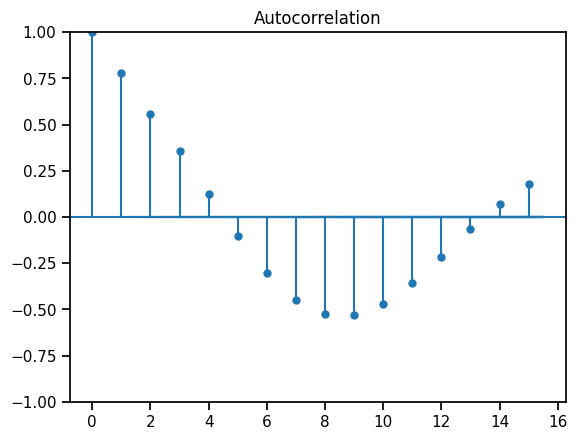

In [4]:
acf_plot = plot_acf(df_tr_sec['acoustic_data'], lags=15,alpha=.05, fft = True)

In [5]:
df_tr_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   acoustic_data    150000 non-null  int64  
 1   time_to_failure  150000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.3 MB


In [6]:
df_tr_sec.describe()

,acoustic_data,time_to_failure
count,150000.00000000,150000.00000000
mean,4.88411333,1.45018249
std,5.10110613,0.01124842
min,-98.00000000,1.43079719
25%,3.00000000,1.44039789
50%,5.00000000,1.44999858
75%,7.00000000,1.45959928
max,104.00000000,1.46909998


In [7]:
df_tr_sec.head()

,acoustic_data,time_to_failure
0,12,1.46909998
1,6,1.46909998
2,8,1.46909998
3,5,1.46909998
4,8,1.46909998


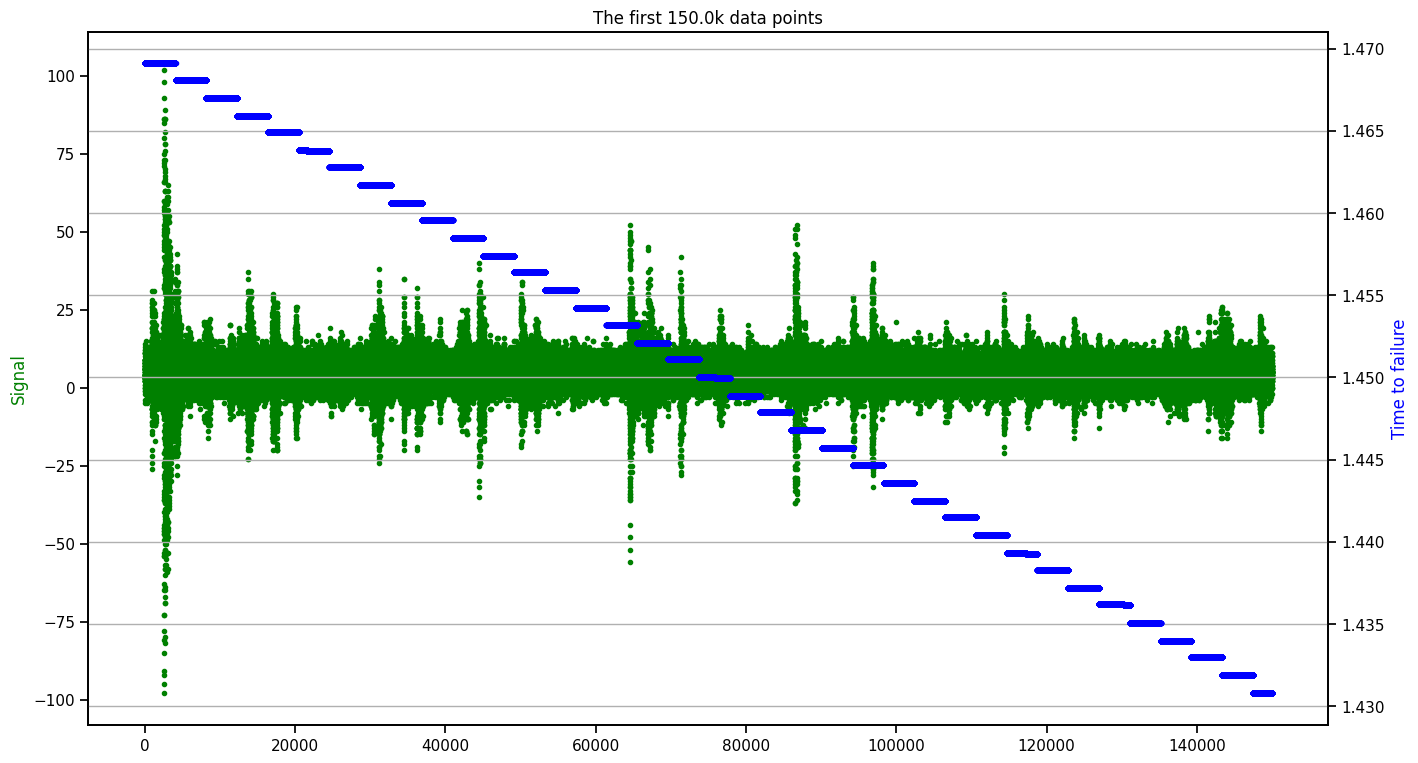

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(16, 9), dpi=100 )
ax2 = ax1.twinx()
ax1.plot(df_tr_sec['acoustic_data'], 'g.')
ax2.plot(df_tr_sec['time_to_failure'], 'b.')
ax1.set_ylabel('Signal', color='g')
ax2.set_ylabel('Time to failure', color='b')
ax2.grid()
plt.title(f'The first {records /1000}k data points');

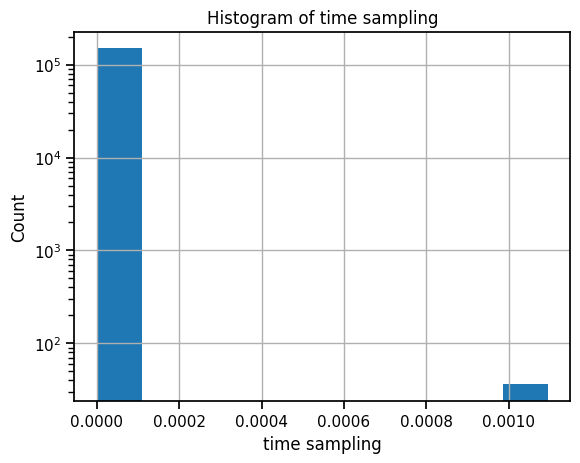

In [9]:
dt = pd.Series(-df_tr_sec['time_to_failure'].diff(), name='dt')
dt.sort_values()[1:].hist()
plt.title('Histogram of time sampling')
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('time sampling');

del df_tr_sec

Therefore, `acoustic_data` is unevenly sampled.

From `time_to_failure`, the equipment may work a while to acquire signal at high frequency (1.1e-9 s), and then take a rest (1e-3 s)before next aquisition.

The sampling rate is not a constant, and the distribution of time step is bimodal with one large timestep and a small timestep.

Try resample with the large timestep later.



## 2.5.2 Load the complete training data <a class="anchor" id="2_5_2Load_the_complete_training_data"></a>

In [10]:
%%time
train_df = pd.read_csv(filename, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: total: 3min 10s
Wall time: 3min 52s


## 2.5.3 Check complete data every 100 records <a class="anchor" id="2_5_3_Check_complete_data_every_100_records"></a>

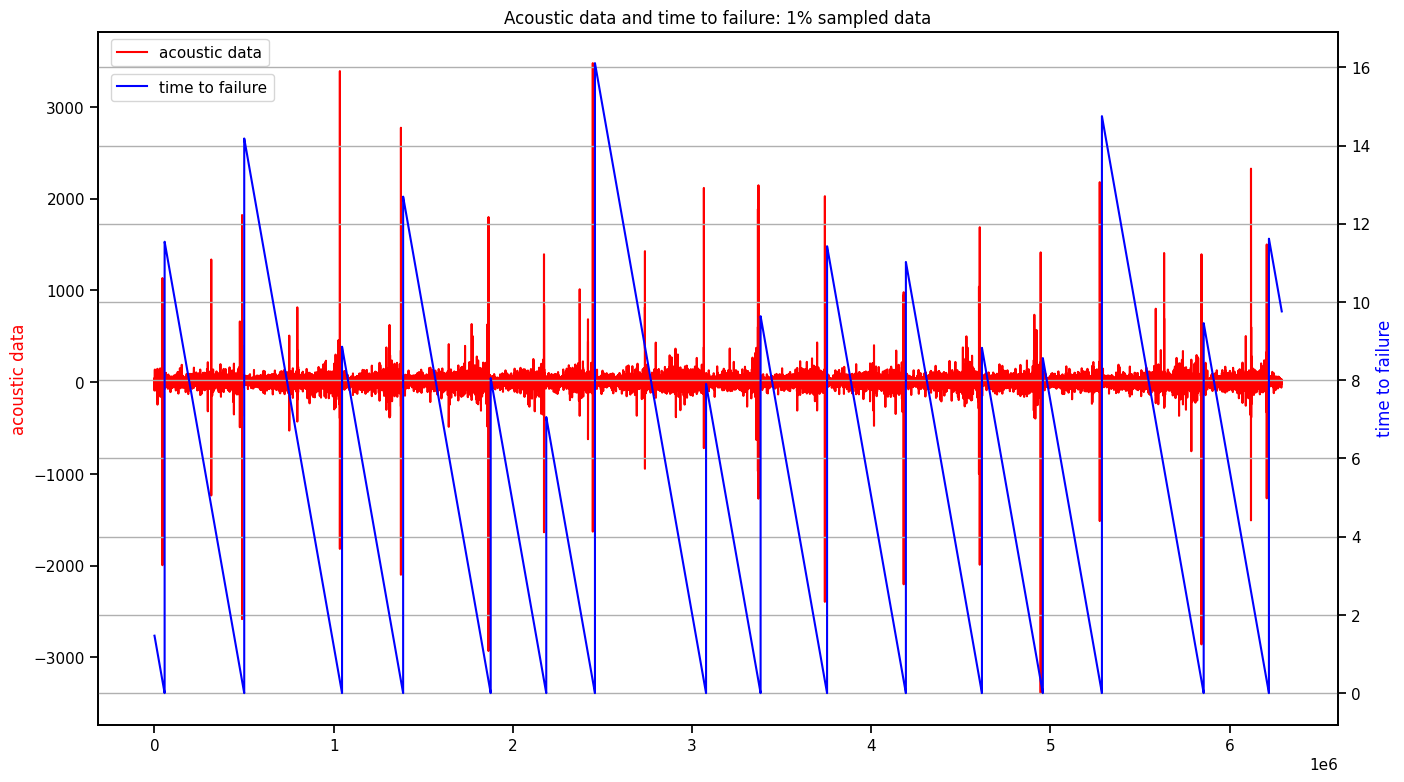

In [11]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(16, 9))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df
del train_df

# 2.6 Load the testing data <a class="anchor" id="2_6_Load_the_testing_data"></a>

In [12]:
testfilepath = "../raw_data/test/"
os.chdir(testfilepath)
testfiles = glob.glob("*.csv")
print(testfiles[0:5])

['seg_00030f.csv', 'seg_0012b5.csv', 'seg_00184e.csv', 'seg_003339.csv', 'seg_0042cc.csv']


In [13]:
def plot_test_file(fileobject):
    df = pd.read_csv(fileobject)
    print(df.describe())
    df.plot(y = 'acoustic_data', figsize = (16,9))
    plt.title(fileobject[0:-4])

         acoustic_data
count  150000.00000000
mean        4.49178000
std         4.89368969
min       -75.00000000
25%         2.00000000
50%         4.00000000
75%         7.00000000
max       115.00000000
         acoustic_data
count  150000.00000000
mean        4.17115333
std         5.92283944
min      -140.00000000
25%         2.00000000
50%         4.00000000
75%         7.00000000
max       152.00000000
         acoustic_data
count  150000.00000000
mean        4.61026000
std         6.94699008
min      -193.00000000
25%         2.00000000
50%         5.00000000
75%         7.00000000
max       248.00000000


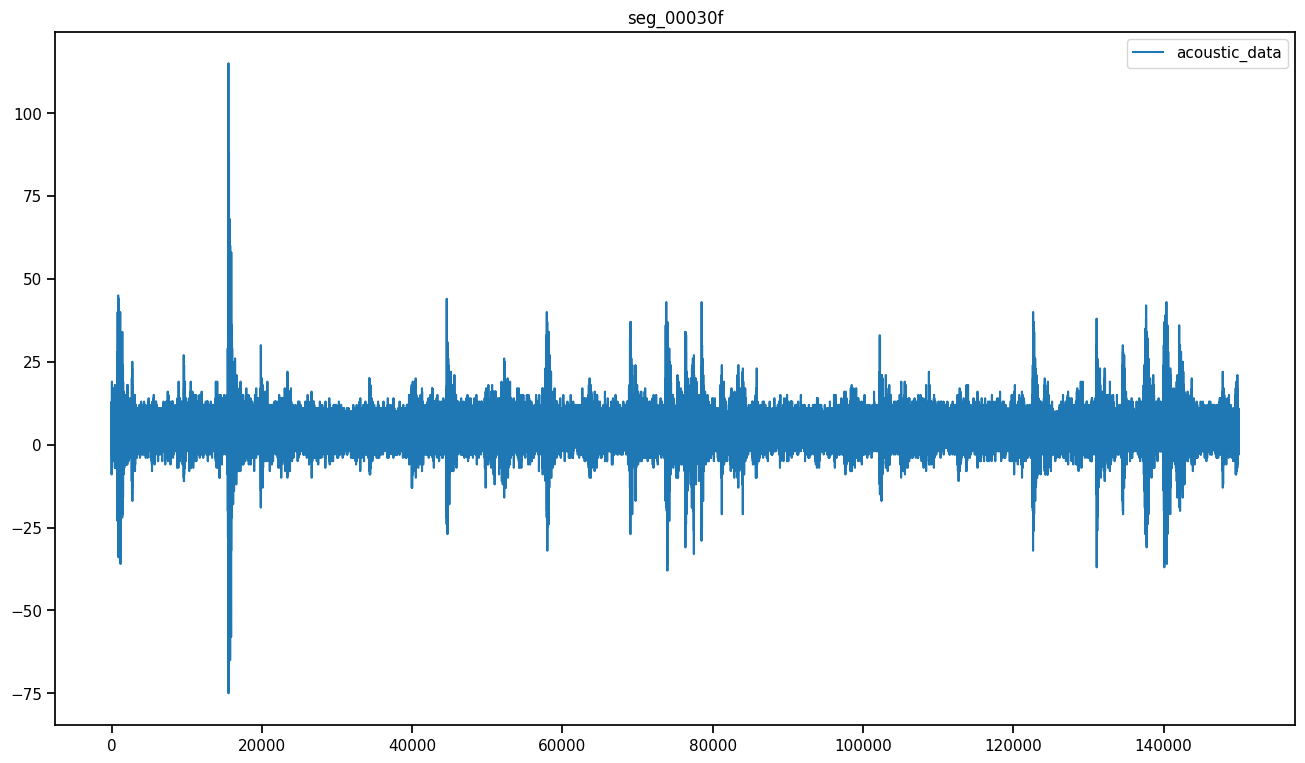

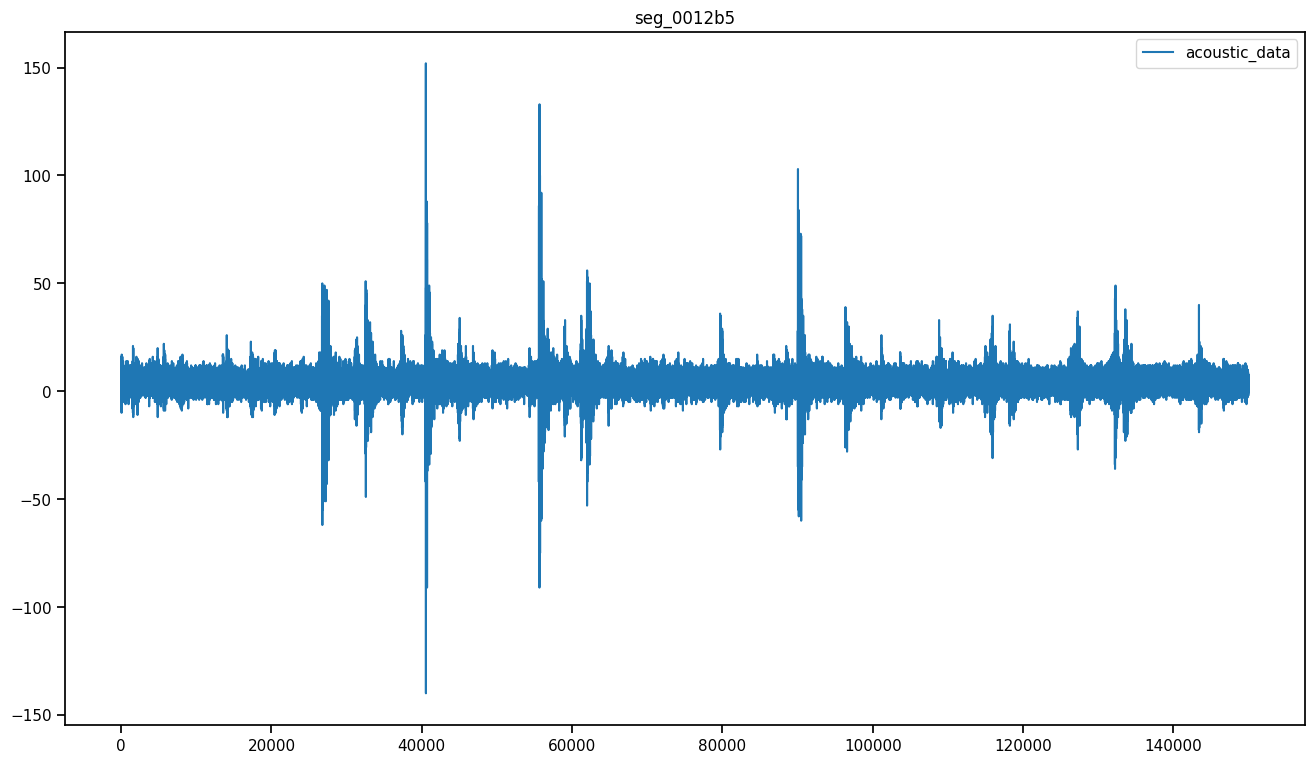

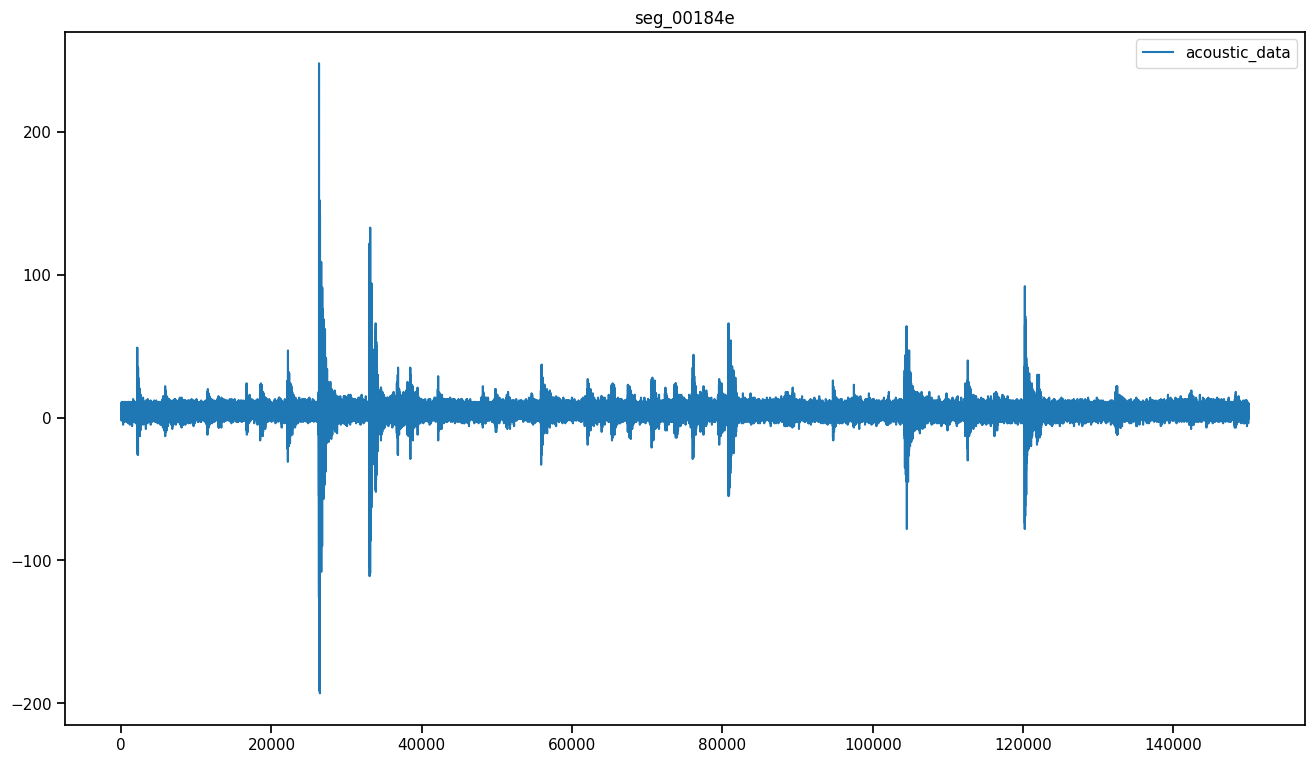

In [14]:
for testfile in testfiles[0:3]:
    plot_test_file(testfile)    

In [15]:
os.chdir("../../Notebooks")

## 2.7 Create labels and features <a class="anchor" id="2_7_Create_labels_and_features"></a>

In [16]:
seg_len = 150_000

### 2.7.1 Generate labels <a class="anchor" id="2_7_1_Generate_labels"></a>

In [17]:
def generate_label(chunk, ttf, chunk_id, invalid_chunk_id):
    """ statistic feature in time_domain"""
    chunk_id += 1
    if (chunk.iloc[-1,1] < chunk.iloc[0,1]) and (chunk.shape[0] == 150_000):
        
        ttf.append(chunk["time_to_failure"].iloc[-1])       
    else:
        invalid_chunk_id.append(chunk_id)
        
    return ttf, chunk_id, invalid_chunk_id


In [18]:
# generate labels
j = -1
eventid = 0
label = []  
chunk_id = -1
invalid_chunk_id = []
for chunk in pd.read_csv(filename, chunksize = seg_len, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}): 
    
    j += 1
    if j % 2000 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)
    
    firsthalf_chunk = chunk.iloc[0:int(len(chunk)/2)]
    if j > 0:
        
        combined_chunk = pd.concat([ lasthalf_chunk, firsthalf_chunk], axis = 0)            
        label, chunk_id, invalid_chunk_id = generate_label(combined_chunk, label, chunk_id, invalid_chunk_id)

    
    lasthalf_chunk = chunk.iloc[int(len(chunk)/2):]          
    label, chunk_id, invalid_chunk_id = generate_label(chunk, label, chunk_id, invalid_chunk_id)

0
2023-02-10 17:22:52.510558
2000
2023-02-10 17:24:35.964034
4000
2023-02-10 17:26:15.818749


In [19]:
label_df = pd.DataFrame(label)
label_df.rename(columns = {0:'ttf'},inplace = True)
label_df.shape
label_df.to_pickle('../data/label.pkl')

In [20]:
label_df = pd.read_pickle('../data/label.pkl')
label_df.shape

(8355, 1)

### 2.7.2 Rolling statistics features in time domain <a class="anchor" id="2_7_2_Rolling_statistics_features_in_time_domain"></a>

In [21]:
# time-domain features
qt5 = lambda x: x.quantile(0.05)
qt25 = lambda x: x.quantile(0.25)
qt75 = lambda x: x.quantile(0.75)
qt95 = lambda x: x.quantile(0.95)
iqr = lambda x : qt75(x) - qt25(x)
# abs_sum = lambda x : sum(abs(x))
statistics_names = ["mean","median","std","kurt","skew","min","max","qt5","qt25","qt75","qt95","iqr"]
statistics_funs = ["mean","median","std","kurt","skew","min","max",qt5,qt25,qt75,qt95,iqr]

# rol_features
rol_funcs_names = ["mean","std","kurt","skew"]
windows = [10, 100,1000]
rol_feature_names = ["rol" + str(w) + "_" + func1 + "_"+ func2 \
                     for w in windows\
                     for func1 in rol_funcs_names \
                     for func2 in statistics_names \
                     ]

# envelope_features
envelope_names = ["rol" + str(w) + "envelope_" + fun \
                  for w in windows\
                  for fun in ["mean","std","max","kurt","skew"]]

# lag_features
lag_names = ["lag" + str(i) for i in range(1,12)]

tfeature_names = statistics_names + rol_feature_names + envelope_names + lag_names
print(len(tfeature_names))

def chunk_statistics(chunk):
    temp_np = chunk['acoustic_data'].agg(statistics_funs)
    return temp_np.tolist()


def rolling_statistics(chunk, windows):
    rtn_list = []

    for w in windows:
        temp_rolling = chunk['acoustic_data'].rolling(w, center = True)
        temp_df = temp_rolling.agg(rol_funcs_names).agg(statistics_funs)
        temp_list = temp_df.values.ravel().tolist()
        rtn_list = temp_list + rtn_list
    return rtn_list     

def rectify_statistics(chunk, windows):
    envelope_stats_list = []
    signal_rectified = chunk['acoustic_data'].apply(np.abs)
    for w in windows:
        signal_envelope = signal_rectified.rolling(w, center = True).mean()
        signal_envelope_list = signal_envelope.agg(["mean","std","max","kurt","skew"]).tolist()
        envelope_stats_list = envelope_stats_list + signal_envelope_list
    return envelope_stats_list

def ac_features(chunk):    
    temp = acf(chunk['acoustic_data'], nlags=11, fft = True)
    return temp[1:].tolist()

def generate_stats(chunk,windows):
    """ statistic feature in time_domain"""
    if (chunk.iloc[-1,1] < chunk.iloc[0,1]) and (chunk.shape[0] == 150_000):
        rol_stats_list = rolling_statistics(chunk, windows)
        stats_list = chunk_statistics(chunk)
        envelope_stats_list = rectify_statistics(chunk, windows)
        ac_list = ac_features(chunk)
        tfeature_list = stats_list +  rol_stats_list + envelope_stats_list + ac_list
        return tfeature_list
    else:
        return None

182


#### generate time-domain features with rolling windows

In [22]:
%%time
j = -1
tfeatures = []
for chunk in pd.read_csv(filename, chunksize = seg_len, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}): 
    j += 1

    if j % 500 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)        
    
    firsthalf_chunk = chunk.iloc[0:int(len(chunk)/2)]
    if j > 0:
        combined_chunk = pd.concat([ lasthalf_chunk, firsthalf_chunk], axis = 0)
        tfeature_list = generate_stats(combined_chunk, windows)
          
        if tfeature_list is not None:
            tfeatures.append( tfeature_list)
 
    lasthalf_chunk = chunk.iloc[int(len(chunk)/2):]
    tfeature_list = generate_stats(chunk, windows)

    if tfeature_list is not None:
        tfeatures.append(tfeature_list)
#     if j > 1:
#         break

tfeature_df = pd.DataFrame(tfeatures, columns = tfeature_names)
tfeature_df.to_pickle('../data/features_time_domain.pkl')

0
2023-02-10 17:26:26.453598
500
2023-02-10 17:46:49.287858
1000
2023-02-10 18:07:06.055035
1500
2023-02-10 18:27:15.452508
2000
2023-02-10 18:47:45.745203
2500
2023-02-10 19:08:06.968685
3000
2023-02-10 19:28:20.268386
3500
2023-02-10 19:48:26.614460
4000
2023-02-10 20:08:42.374937
CPU times: total: 2h 48min 16s
Wall time: 2h 50min 9s


In [23]:
tfeature_df = pd.read_pickle('../data/features_time_domain.pkl')
tfeature_df.shape

(8355, 182)

Heat map of correlations between labels and basic statistical features:

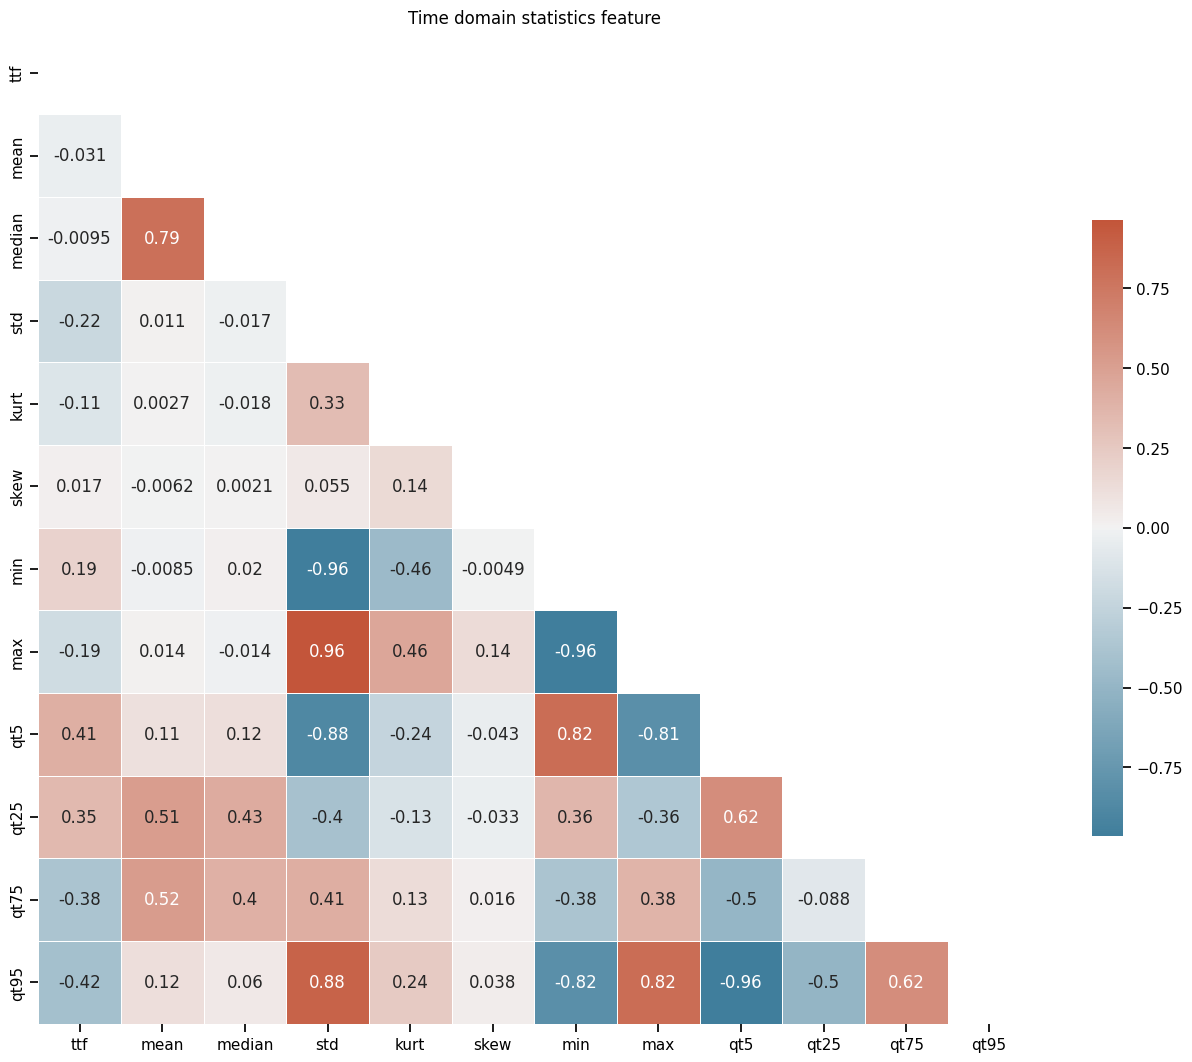

In [24]:
# 10 features
statistic_feature_df = pd.concat([label_df,tfeature_df.iloc[:,0:11]], axis = 1)
corr_lag = statistic_feature_df.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap,  center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title('Time domain statistics feature');

Heat map of correlations between labels and auto-correlation features:

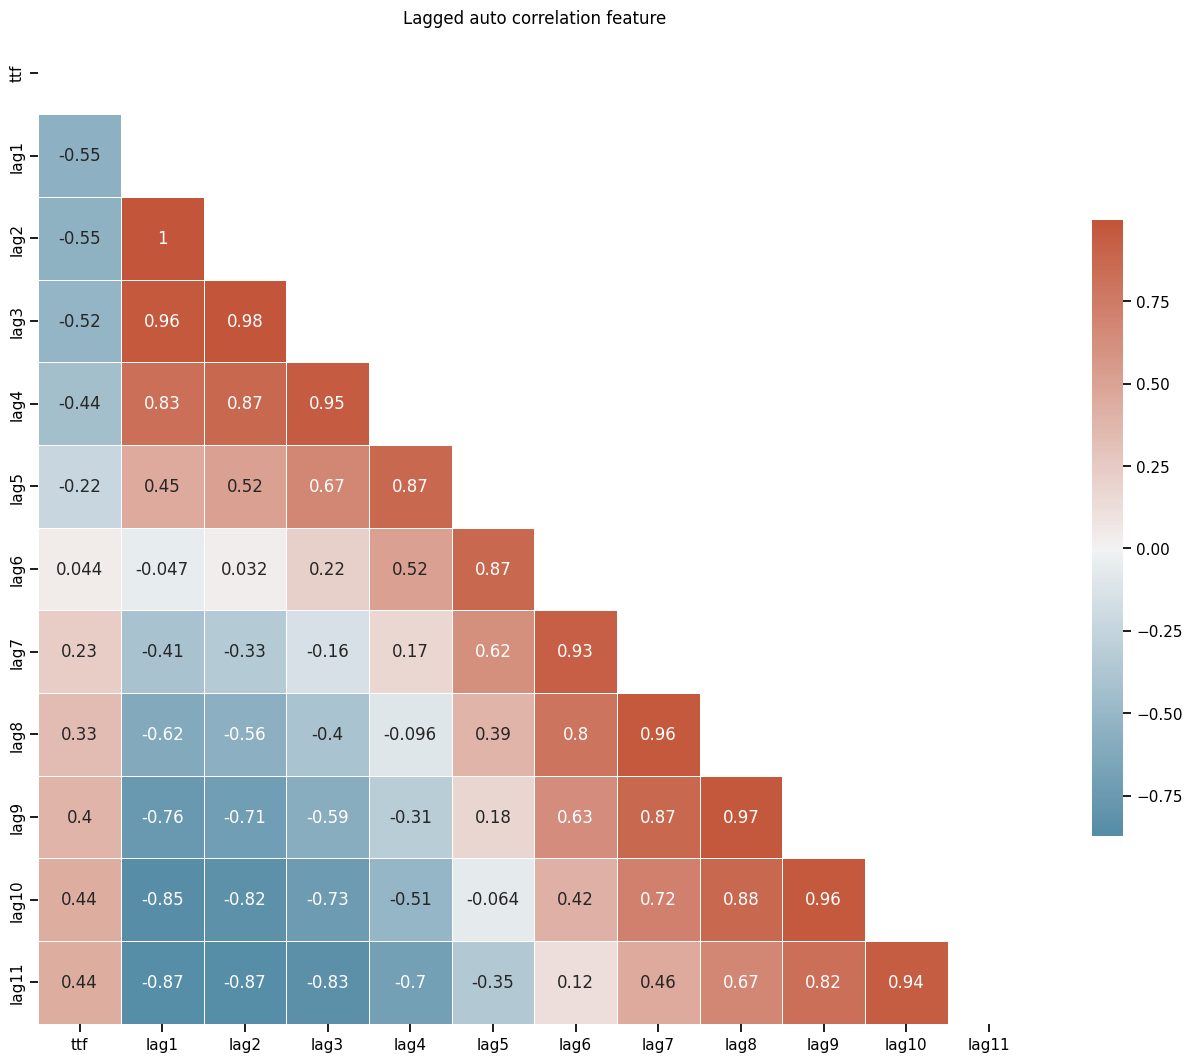

In [25]:
# 10 features
tlag_feature_df = pd.concat([label_df,tfeature_df[[col for col in list(tfeature_df.columns) if "lag" in col]]], axis = 1)
corr_lag = tlag_feature_df.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap,  center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title('Lagged auto correlation feature');

### 2.7.3 Generate features in frequency domain <a class="anchor" id="2_7_3_Generate_features_in_frequency_domain"></a>

#### Rolling statistics and segmented features of amplitude spectrum

In [26]:
def roll_seg_median(spectrum_np, seg_len):
    interval = int(seg_len/20)
    roll_spectrum_seg_median = []
    for i in range(10):
        idx = list((np.arange(0,interval) + interval * i))
        roll_spectrum_seg_median.append(np.median(spectrum_np[idx]))

    return roll_spectrum_seg_median

In [27]:
# rolling functions for amplitude spectrum
def rolling_amp_spectrum(chunk, windows, seg_len):
    if (chunk.iloc[-1,1] < chunk.iloc[0,1]) and (chunk.shape[0] == seg_len):
        roll_amp_spectrum_statistics = []
        roll_amp_spectrum_seg_median= []
        sp = np.fft.fft(chunk['acoustic_data'])
        amp_sp = pd.Series(np.abs(sp))[0:int(seg_len/2)]
        for w in windows:
            temp_rolling_median = amp_sp.rolling(w, center = True).agg(np.median)
            roll_amp_spectrum_statistics.append(temp_rolling_median.
                                                agg(["mean","median","std","kurt","skew","min","max",qt25,qt75,iqr])) #   
            roll_amp_spectrum_seg_median.append(roll_seg_median(temp_rolling_median, seg_len)) 
        roll_amp_spectrum_statistics = [j for sub in roll_amp_spectrum_statistics for j in sub]        
        roll_amp_spectrum_seg_median = [j for sub in roll_amp_spectrum_seg_median for j in sub]

        return roll_amp_spectrum_statistics + roll_amp_spectrum_seg_median
    else:
        return None

In [28]:
%%time
# rolling statistic feature in freq_domain
freq_stat_names = ["mean","median","std","kurt","skew","min","max","qt25","qt75","iqr"]
windows = [5000, 10000, 50000] #
amp_spectrum_rol_feature_names = ["amp_sp_rol" + str(w) + "_"+ freq_stat_name \
                                  for w in windows \
                                  for freq_stat_name in freq_stat_names] 
amp_spectrum_rol_seg_feature_names = ["amp_sp_rol" + str(w) + "seg_" + str(i) for w in windows for i in range(10)]

j = -1
roll_AP_statistics = []

for chunk in pd.read_csv(filename, chunksize = seg_len, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}):   
    j += 1
    if j % 1000 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)
    
    firsthalf_chunk = chunk.iloc[0:int(len(chunk)/2)]
    if j > 0:
        combined_chunk = pd.concat([ lasthalf_chunk, firsthalf_chunk], axis = 0)
        roll_amp_spectrum_statistics = rolling_amp_spectrum(combined_chunk, windows, seg_len)
        
        if roll_amp_spectrum_statistics is not None:
            roll_AP_statistics.append( roll_amp_spectrum_statistics)
    lasthalf_chunk = chunk.iloc[int(len(chunk)/2):]
    roll_amp_spectrum_statistics = rolling_amp_spectrum(chunk, windows, seg_len)
    if roll_amp_spectrum_statistics is not None:
        roll_AP_statistics.append(roll_amp_spectrum_statistics)
#     if j > 1:
#         break

roll_AP_statistics_df = pd.DataFrame(roll_AP_statistics, columns = amp_spectrum_rol_feature_names + amp_spectrum_rol_seg_feature_names)
roll_AP_statistics_df.dropna(axis = 1, inplace = True)
roll_AP_statistics_df.to_csv('../data/roll_amp_spectrum_statistics.csv')

0
2023-02-10 20:16:39.676644
1000
2023-02-10 20:43:56.052751
2000
2023-02-10 21:06:06.857770
3000
2023-02-10 21:24:14.722381
4000
2023-02-10 21:42:25.156649
CPU times: total: 1h 24min 7s
Wall time: 1h 29min 15s


In [29]:
roll_AP_statistics_df = pd.read_csv('../data/roll_amp_spectrum_statistics.csv', index_col = 0)

#### Auto-correlation features of amplitude spectrum

In [30]:
# amplitude spectrum trend (ac)
def ac_spectrum(chunk):
    if (chunk.iloc[-1,1] < chunk.iloc[0,1]) and (chunk.shape[0] == 150_000):
        sp = np.fft.fft(chunk['acoustic_data'])
        SP = np.abs(sp)
        ac_spectrum_list = acf(SP, nlags=11, fft = True)[1:]
        return ac_spectrum_list
    else:
        return None

In [31]:
# autocorrelation feature in freq_domain

j = -1
ac_spectrum_list = []

for chunk in pd.read_csv(filename, chunksize = seg_len, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}):   
    j += 1
    if j % 1000 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)
    
    firsthalf_chunk = chunk.iloc[0:int(len(chunk)/2)]
    if j > 0:
        combined_chunk = pd.concat([ lasthalf_chunk, firsthalf_chunk], axis = 0)
        ac_spectrum_row = ac_spectrum(combined_chunk)
        if ac_spectrum_row is not None:
            ac_spectrum_list.append( ac_spectrum_row)
    lasthalf_chunk = chunk.iloc[int(len(chunk)/2):]
    ac_spectrum_row = ac_spectrum(chunk)
    if ac_spectrum_row is not None:
        ac_spectrum_list.append(ac_spectrum_row)
#     if j > 0:
#         break
ac_amp_spec_df = pd.DataFrame(ac_spectrum_list, columns = ['amp_spec_ac' + str(i) for i in range(1,12)])
ac_amp_spec_df.to_pickle('../data/ac_amp_spec.pkl')

0
2023-02-10 21:45:55.947267
1000
2023-02-10 21:49:02.717572
2000
2023-02-10 21:52:12.412535
3000
2023-02-10 21:55:18.765894
4000
2023-02-10 21:58:23.590781


In [32]:
ac_amp_spec_df = pd.read_pickle('../data/ac_amp_spec.pkl')

#### Spectrogram features

In [33]:
# spectrogram features
def spectrogram_feature(chunk, HOP_LENGTH, SIZE_WINDOW):    
    if (chunk.iloc[-1,1] < chunk.iloc[0,1]) and (chunk.shape[0] == 150_000):
        spec = lr.stft(chunk['acoustic_data'].values.astype(float), hop_length = HOP_LENGTH, n_fft = SIZE_WINDOW)
        spec_rectified = np.abs(spec)
        mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S = spec_rectified))
        mean_centroids = np.mean(lr.feature.spectral_centroid(S = spec_rectified))
        return mean_centroids, mean_bandwidth
    else:
        return None, None

In [34]:
# spectrogram features
HOP_LENGTH = 2**6
SIZE_WINDOW = 2**7
bandwidths = []
centroids = []
j = -1

for chunk in pd.read_csv(filename, chunksize = seg_len, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}):   
    j += 1
    if j % 1000 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)
    
    firsthalf_chunk = chunk.iloc[0:int(len(chunk)/2)]
    if j > 0:
        combined_chunk = pd.concat([ lasthalf_chunk, firsthalf_chunk], axis = 0)
        mean_centroids, mean_bandwidth = spectrogram_feature(combined_chunk, HOP_LENGTH, SIZE_WINDOW)
        if mean_centroids is not None:
            centroids.append(mean_centroids)
            bandwidths.append(mean_bandwidth)
        
    lasthalf_chunk = chunk.iloc[int(len(chunk)/2):]
    mean_centroids, mean_bandwidth = spectrogram_feature(chunk, HOP_LENGTH, SIZE_WINDOW)
    if mean_centroids is not None:
        centroids.append(mean_centroids)
        bandwidths.append(mean_bandwidth)
#     if j > 1:
#         break
spectrogram_feature_df = pd.DataFrame({'mean_centroids':centroids, 'bandwidth':bandwidths})
spectrogram_feature_df.to_pickle('../data/spectrogram_feature.pkl')

0
2023-02-10 21:58:59.837114
1000
2023-02-10 22:00:39.495877
2000
2023-02-10 22:02:20.480895
3000
2023-02-10 22:03:59.140974
4000
2023-02-10 22:05:38.330125


In [35]:
spectrogram_feature_df = pd.read_pickle('../data/spectrogram_feature.pkl')

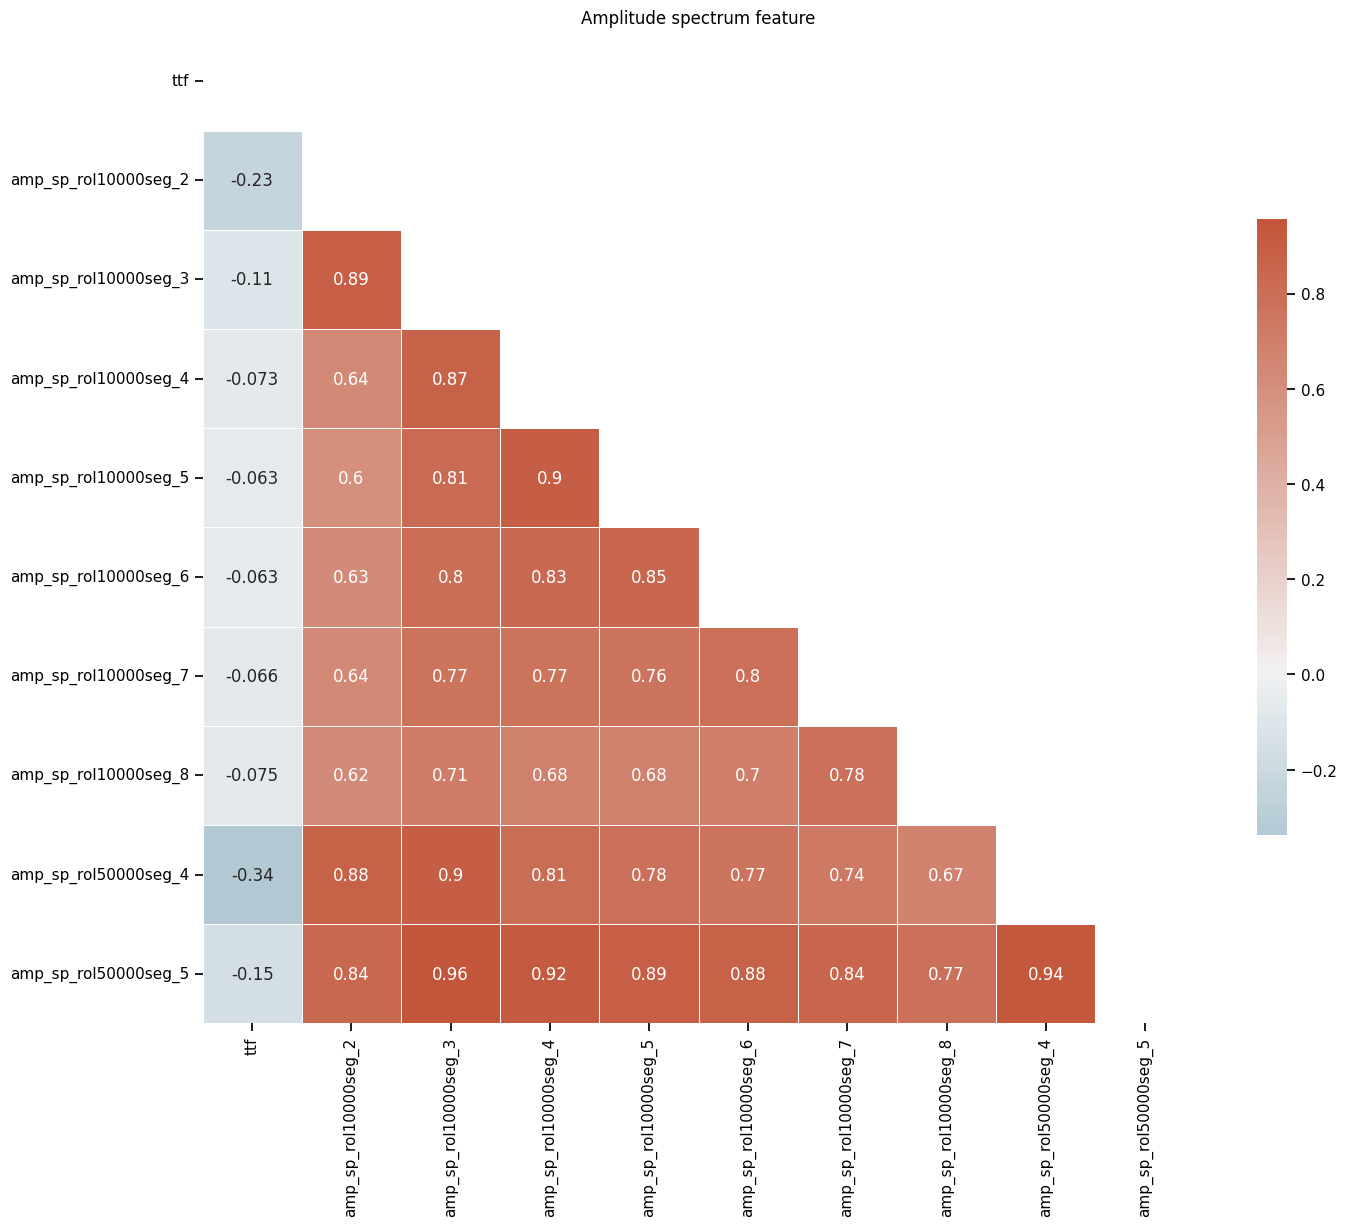

In [36]:
corr_lag = roll_AP_statistics_df.iloc[:,[0]+list(range(40,49))].corr()

mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap,  center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title('Amplitude spectrum feature');

### 2.7.4 Concat features in time and frequency domains <a class="anchor" id="2_7_4_Concat_features_in_time_and_frequency_domains"></a>

In [37]:
train_df = pd.concat([label_df, 
                      tfeature_df, 
                      roll_AP_statistics_df.drop(columns = "ttf"), 
                      ac_amp_spec_df, 
                      spectrogram_feature_df], axis = 1) # rolling_feature_td_df
train_df.head()

,ttf,mean,median,std,kurt,skew,min,max,qt5,qt25,...,amp_spec_ac4,amp_spec_ac5,amp_spec_ac6,amp_spec_ac7,amp_spec_ac8,amp_spec_ac9,amp_spec_ac10,amp_spec_ac11,mean_centroids,bandwidth
0,1.43079722,4.88411333,5.0,5.10110613,33.66248129,-0.02406117,-98.0,104.0,-2.0,3.0,...,0.27390338,0.28139753,0.26339565,0.27409272,0.26580440,0.27540197,0.27093498,0.27565392,3046.81558414,3172.69163977
1,1.41169584,4.74680000,5.0,6.17338350,116.79737733,0.52628358,-154.0,181.0,-2.0,2.0,...,0.40377852,0.38321378,0.39449875,0.40342321,0.39341535,0.37761118,0.39778747,0.39368300,3061.90105937,3168.38179010
2,1.39149892,4.72576667,5.0,6.58882378,98.75851718,0.39056050,-154.0,181.0,-2.0,2.0,...,0.43279549,0.41252975,0.41789450,0.43398313,0.42032385,0.41643044,0.41198456,0.44162278,3056.58770974,3159.49818494
3,1.37229753,4.75300000,5.0,5.71503591,33.74477916,-0.10766378,-115.0,111.0,-2.0,2.0,...,0.33713224,0.32605860,0.33860042,0.32916784,0.33125597,0.33546813,0.33400640,0.35154049,3059.96594183,3163.89581601
4,1.35319614,4.90639333,5.0,6.96739703,33.55521141,0.21739056,-106.0,140.0,-3.0,2.0,...,0.40931783,0.40614344,0.41107361,0.40762849,0.40858249,0.39950694,0.41143976,0.40667606,2976.35196359,3123.41841751


# 2.8 Save data <a class="anchor" id="2_8_Save_data"></a>

In [38]:
train_df.to_pickle('../data/train_df243.pkl')

# 2.9 Summary <a class="anchor" id="2_9_Summary"></a>

For the training data:
* The data has zero missing values for both columns
* The data has only two column ,`acoustic_data` in int type and `time_to_failure` in float type. `time_to_failure` is our target.
* The data has 629,145,480 records, too large to operate.
* `acoustic_data` is the acoustic emission signal (amplitude), consisting of many peaks and troughs. 
* `time_to_failure` decreases from a value to zero repeatedly. The data should be truncated based on it.
* 17 segments were obtained after analyzing chunk data in the rawdata. 
* Each training segment has different time length
* The first one only has about two seconds record to earthquake. The last one is not complete because the `time_to_failure` is 9.75 s, far from zero.
* After `acoustic_data` reaches a extremly large event, the eqrthquake occurs soon in each training segment, and `time_to_failure` is less than 0.5s.

For the testing data:
* Only one row in each file, which is the `acoustic_data`
* Each segment contains 150k records, a small segment from a complete earthquake event. By comparision, records in training data is about 200 times of the test data. This guides us creation of labels from the training data
* Similar to the training data, the average `acoustic_data` of a test data are small, while some abnormal `acoustic_data` exists. These determines what a feature is.
* Most test data may not contain the extremly large event with an absolute of amplitude over 1000. They contains peaks at a scale of several hundred amplitude